# Breaking Peaked Quantum Circuits Classically 

### **What Are Peaked Circuits?**

**Peaked Circuits** are quantum circuits whose structure resembles that of a random quantum circuit but whose output probability distribution is "peaked" on one specific bitstring. In other words, unlike a random quantum circuit for which the output distribution is nearly flat--with each of the $2^N$ bitstring amplitude exponentially small--in a peaked circuit a particular bitstring, called **peak bitstring**, occurs with exponentially high probability compared to all other bitstrings. 

---

### **Why Are Peaked Circuits Interesting?**

Large, well-constructed peaked circuits are strong candidates for demonstrating **near-term quantum advantage**, thanks to two key properties:

1. **Quantum hardware friendliness:**  
    The dominant bitstring appears with such a sharply amplified probability that the peak remains identifiable even under realistic levels of device noise and measurement error.  
   This robustness makes peaked circuits far easier to run reliably on today’s noisy quantum hardware.

2. **Classical intractability:**  
   Although the output distribution is dominated by one bitstring, the internal randomness renders these circuits extremely difficult for classical simulators to simulate accurately or to reverse-engineer.   

This combination makes peaked circuits an ideal playground for studying the limits of classical simulation and the onset of quantum advantage.

**Furthermore: Cryptographic Implications**  
   When the input is not fixed (to be $|0\rangle$), even a quantum computer cannot efficiently determine whether a given circuit is peaked or not.  
   As a result, finding the input basis state on which a circuit peaks is also hard, which suggests potential use in post-quantum cryptographic settings.

For more information on peaked circuits, their construction, and applications, we refer the reader to the BlueQubit team’s recent preprint on peaked circuits [[1]](#ref-1).

---

### **In This Tutorial**

We will explore several **classical strategies for attacking (“breaking”) peaked circuits**, including methods for recovering the hidden peak bitstring and exploiting structural correlations. These techniques help illuminate both the capabilities and limitations of classical algorithms when faced with random-looking but highly structured quantum circuits.


In [1]:
import time
import warnings
import os

#os.environ["BLUEQUBIT_PPS_DO_NO_USE_PARALLEL_COMPUTE"] = "1
os.environ["BLUEQUBIT_DEQART_INTERNAL_DISABLE_STRICT_VALIDATIONS"] = "1"

warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from qiskit import QuantumCircuit, transpile

import bluequbit
bq = bluequbit.init()

[BQ-PYTHON-SDK][WARNING] - Beta version 0.18.1b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Using execution mode from environment variable BLUEQUBIT_EXECUTION_MODE: local


### Get Circuits

In [2]:
import requests
from qiskit import QuantumCircuit

def load_qasm(name):
    url = f"https://raw.githubusercontent.com/BlueQubitDev/sdk-examples/main/peaked_circuits/qasm/{name}"
    qasm = requests.get(url).text
    return QuantumCircuit.from_qasm_str(qasm)


## 🏞️💾 Base Camp: StateVector Simulation

We begin with an 8-qubit peaked circuit. This peaked circuit is constructed using the method outlined in [[2]](#ref-2). In this approach, a peaked circuit is composed of two components: a **Random block** \(R\), followed by a **Parametric block** \(P\). The parametric block is then trained to **maximize the output probability of a chosen target bitstring**, thereby producing the characteristic probability peak. 

More on the structure appears in [Section: Structure of Peaked Circuits](#structure-section).

Gates: OrderedDict([('ry', 40), ('rz', 40), ('rzz', 24), ('cz', 16)])


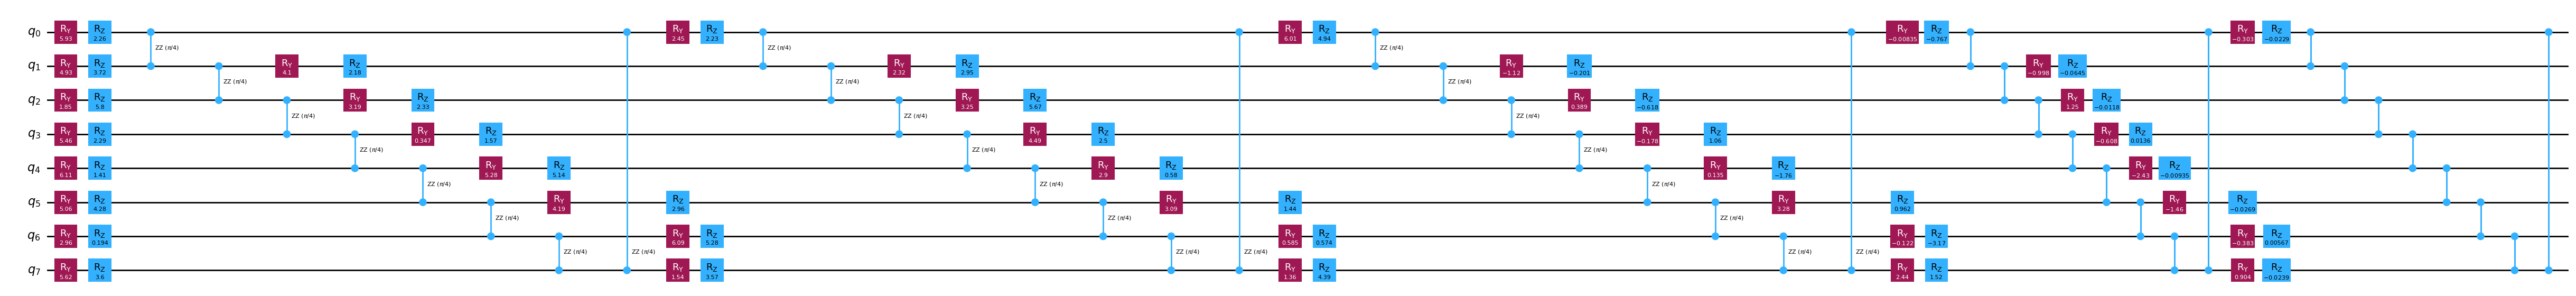

In [3]:
qc = load_qasm("peaked_circuit_8q_shallow.qasm")

print(f"Gates: {qc.count_ops()}")
qc.draw("mpl", fold=-1)

Let us now execute this circuit using BlueQubit's default **StateVector Simulator**.  
When `shots=None` (or when the `shots` argument is omitted), the simulator returns the **exact output probability distribution**, which is available for circuits with up to 16 qubits.

In [4]:
results = bq.run(qc)
probs = results.get_counts()

top10_probs = dict(sorted(probs.items(), key=lambda x: x[1], reverse=True)[:10]) # get top 10
top10_probs 

[BQ-PYTHON-SDK][INFO] - Total memory of the host: 15 GB
[BQ-PYTHON-SDK][INFO] - Maximum number of qubits for statevector simulation supported on this host's CPU: 30


{'11001101': 0.7257371544837952,
 '11010101': 0.06531105935573578,
 '11010001': 0.04949243366718292,
 '11000001': 0.03223709017038345,
 '10101101': 0.020631132647395134,
 '11001110': 0.019463786855340004,
 '11011001': 0.009708735160529613,
 '01001110': 0.00953588541597128,
 '11001011': 0.008768985979259014,
 '11010011': 0.004205720964819193}

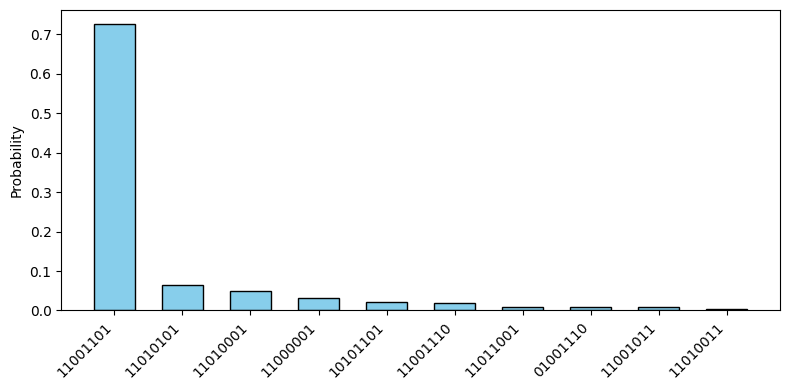

In [5]:
import matplotlib.pyplot as plt

bitstrings = list(top10_probs.keys())
probs = list(top10_probs.values())

plt.figure(figsize=(8, 4))
plt.bar(range(len(probs)), probs, tick_label=bitstrings, color='skyblue', edgecolor='black', width=0.6)
plt.ylabel("Probability")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

📊 We clearly see that the output bitstring `"11001101"` is the peak bitstring, with a peak weight of approximately 73%. 


Notice that nothing in the circuit’s appearance reveals that it is a peaked circuit — nor, assuming it were peaked, which bitstring it hides.  
Only by simulating the circuit (or running it on a quantum device!) can we confirm whether it is peaked and identify the corresponding peak bitstring.

## 🌄🔗 Tree Line: MPS Simulations

Let us now move to the next level — where the circuit grows large enough that a full state-vector simulation becomes impractical.  
To tackle this regime, we turn to **Matrix Product State (MPS) simulation**, a powerful tensor-network method widely used in quantum physics.

MPS is particularly effective when the quantum state exhibits **limited entanglement**, allowing the wavefunction to be compressed into a chain of low-rank tensors. Because of this, MPS has become one of the most reliable and scalable classical simulation techniques for a wide variety of quantum systems.

In [6]:
qc = load_qasm("sharp_peak_44q.qasm")
#qc = QuantumCircuit.from_qasm_file("peaked_circuit_42q.qasm")

print(qc.count_ops())

OrderedDict([('u3', 399), ('cz', 178)])


Before running the simulation, let us recall the two key parameters that govern the performance of the MPS method: the **bond dimension** and the number of **shots**.

**• Bond dimension (`mps_bond_dimension`)**  
The bond dimension controls how much entanglement the MPS representation is allowed to capture.  
During each gate application, the MPS is compressed using an SVD, and only the $\chi$ largest Schmidt coefficients are retained, where $\chi$ is the chosen bond dimension.  
A larger bond dimension produces a more faithful approximation of the true quantum state, but at the cost of **increased memory usage and longer simulation time**.

**• Number of shots (`shots`)**  
For a fixed MPS approximation, the number of shots determines the statistical accuracy of the sampled output distribution.  
Higher shot counts yield histograms that more closely match the probabilities encoded in the MPS state.  
However, **increasing the number of shots directly increases runtime**, since each shot corresponds to an independent sample drawn from the MPS.

With these parameters in mind, let us now run the MPS simulation.



In [7]:
# Run the circuit using BlueQubit's MPS simulator.

results_mps = bq.run(
    qc,
    device="mps.cpu",
    shots=500,
    options={"mps_bond_dimension": 32},
)

print(f"MPS simulation runtime: {results_mps.run_time_ms} ms")

MPS simulation runtime: 16000 ms


In [8]:
# Extract the sampled bitstring counts from the MPS simulation
counts = results_mps.get_counts()

# Sort the bitstrings by frequency (descending) and take the top 10
top10_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]

# The bitstring with the highest count is our candidate peak bitstring
peak_bitstring_mps = top10_counts[0][0]

print("Top 10 most frequent bitstrings from MPS Simulation: \n")
for bitstring, count in top10_counts:
    print(f"  {bitstring}: {count}")
print(f"\nPeak bitstring inferred from MPS samples: {peak_bitstring_mps}")

Top 10 most frequent bitstrings from MPS Simulation: 

  10001101010101010000011111001101000100011010: 57
  10001101010100100000011111001101000100011010: 9
  10001101010101010001010111001101000100011010: 5
  11001101010101010000011111001101000100011010: 4
  10001101010101100000011111001101000100011010: 3
  10001101010101011010011111001101000100011010: 3
  10001100101101010000011111001101000100011010: 3
  10001101010101010001101111001101000100011010: 3
  10001101010111000000011111001101000100011010: 2
  10001101101101010000011111001101000100011010: 2

Peak bitstring inferred from MPS samples: 10001101010101010000011111001101000100011010


#### 🧮 Majority-voting
You may have noticed that almost all of the MPS samples lie at a **small Hamming distance** from the peak bitstring. This behavior is not accidental: it is an artifact of how the peaked circuit was constructed.  

This observation can be turned into an effective attack strategy. If the sampled bitstrings cluster tightly around the peak, then even an MPS simulation with a **very small bond dimension** can recover the peak bitstring via a simple **majority-vote** procedure: for each qubit, take the bit value that appears most frequently across the samples.

Such a strategy is resource-efficient and can succeed even when the MPS approximation is relatively crude.

🔶 Before moving on to the next level, it is worth noting an important caveat: The circuit used here was intentionally chosen so that MPS performs well, but quantum-advantage–level peaked circuits are designed to break MPS-style simulations.

Such circuits exhibit **high entanglement across many bipartitions** and, in architectures with richer connectivity (e.g., heavy-hex, or all-to-all layouts), the required bond dimension can grow rapidly.

Consequently, while MPS is highly effective for structured or weakly entangled systems, its strengths do not automatically carry over to **random or adversarially constructed peaked circuits**.


<a id="marginals-section"></a>
## 🏔️🎯 Summit Push: Marginal Attacks

➕ The majority-vote attack introduced earlier can be refined further.  
Because the sampled bitstrings already cluster near the true peak, the **local biases** at each qubit position can be exploited more systematically.  
This leads to the **marginal-attack strategy**, the focus of this section.

### 🎲 Probability of a Bitstring and the Marginal-Attack Strategy

For a quantum state $|\psi\rangle$, the probability of observing a particular bitstring $|b\rangle$ is given by the expectation value of the projector onto that bitstring:

$$
P(b) = \langle \psi | \Pi_b | \psi \rangle, \qquad 
\Pi_b = |b\rangle\langle b|.
$$

Each single-qubit factor of $\Pi_b$ can be rewritten using Pauli-$Z$ operators:

$$
\Pi_b = \bigotimes_{i} \frac{I + (-1)^{b_i} Z_i}{2}.
$$

Let $\mathbf{s}$ denote the unknown peak bitstring.  
When the peak has sufficiently high weight — or when the output distribution is sharply concentrated in a small Hamming ball around $\mathbf{s}$ — each qubit exhibits a **strong marginal bias** toward its corresponding bit value $s_i$.

To make this precise, let $x_i \in \{0,1\}$ denote the measurement outcome on qubit $i$.  
The **single-qubit marginal probability** is

$$
P(x_i = 0) = \frac{1 + \langle Z_i \rangle}{2}, \qquad
P(x_i = 1) = \frac{1 - \langle Z_i \rangle}{2}.
$$

Thus, whenever $\langle Z_i \rangle$ is significantly positive or negative, the $i$-th bit of the peak bitstring can be inferred directly from the **sign** of the expectation value:

- If $\langle Z_i \rangle > 0$, the marginal favors $x_i = 0$.  
- If $\langle Z_i \rangle < 0$, the marginal favors $x_i = 1$.

This bit-by-bit reconstruction forms the core of the **marginal attack**.


### 💻 Implementing the Marginal Attack with Pauli-Path Simulator

Let us now implement the **marginal attack** on a peaked circuit using **BlueQubit’s Pauli-Path Simulator (PPS)**.  
We will compute the single-qubit $\langle Z_i \rangle$ expectation values, and then assemble a candidate peak bitstring $\mathbf{\hat s}$ by taking each bit from the **sign** of the corresponding marginal.


In [9]:
qc = load_qasm("peaked_circuit_42q.qasm")
# qc = QuantumCircuit.from_qasm_file("sharp_peak_44q.qasm")
qc.remove_final_measurements(inplace=True)

# Print basic circuit information
print(f"Number of qubits:        {qc.num_qubits}")
print(f"Gate counts:             {qc.count_ops()}")
print(f"Total instructions:      {len(qc.data)}")

Number of qubits:        42
Gate counts:             OrderedDict([('rz', 1519), ('sx', 958), ('x', 440), ('cz', 196)])
Total instructions:      3113


In [10]:
def make_single_qubit_Z_ops(qc):
    """
    Construct the list of single-qubit Z observables for the circuit.
    Each entry is a list containing a single (Pauli_string, coefficient) tuple.
    """
    n = qc.num_qubits
    Z_ops = []
    for i in range(n):
        pauli_str = ''.join('Z' if j == i else 'I' for j in range(n))
        # Reverse due to Qiskit's little-endian ordering of qubits
        pauli_str = pauli_str[::-1]
        Z_ops.append([(pauli_str, 1.0)])
    return Z_ops

# Generate all single-qubit Z observables for this circuit
Z_ops = make_single_qubit_Z_ops(qc)
assert len(Z_ops) == qc.num_qubits    

We evaluate the single-qubit expectation values ⟨Zᵢ⟩ using using the `pauli-path` device.

⚛️ Pauli-Path Simulation (PPS) is a relatively new method to classically compute observable expectation values by propagating Pauli operators backward through the circuit (Heisenberg evolution) and truncating low-weight Pauli paths along the way.  
This approach enables fast, approximate evaluation of observables on circuits that would otherwise be expensive to simulate exactly.

The `options` dictionary below specifies two PPS parameters:

- **`pauli_path_truncation_threshold`** — sets the cutoff for discarding Pauli paths with small coefficients, trading a small amount of approximation for significant speed improvements.  
- **`pauli_path_circuit_transpilation_level`** — controls how aggressively PPS transpiles the circuit before simulation (higher values allow more simplification).

➡️ For more details on PPS and its configuration, see the full tutorial: [PPS tutorial](https://app.bluequbit.io/tutorial/2tmSchlAGgRBTKxC)


In [11]:
z_expvals = []

pps_options = {
    "pauli_path_truncation_threshold": 1e-2,
    "pauli_path_circuit_transpilation_level": 1,
}

start_time = time.time()

# Compute ⟨Z_i⟩ for each qubit
for i, Z_op in enumerate(Z_ops):
    result = bq.run(qc, device="pauli-path", pauli_sum=Z_op, options=pps_options)
    exp_val = result.expectation_value
    z_expvals.append(exp_val)
    print(f"qubit {i:2d}:  <Z_{i}> = {exp_val:.6f}")
    
end_time = time.time()
time_taken = end_time - start_time

print(f"\nTotal time taken for all marginals with PPS: {time_taken:.2f} seconds")

qubit  0:  <Z_0> = -0.241242
qubit  1:  <Z_1> = -0.996451
qubit  2:  <Z_2> = 0.461164
qubit  3:  <Z_3> = -0.909606
qubit  4:  <Z_4> = -0.368329
qubit  5:  <Z_5> = -0.837616
qubit  6:  <Z_6> = -0.866820
qubit  7:  <Z_7> = 0.608537
qubit  8:  <Z_8> = 0.140050
qubit  9:  <Z_9> = 0.588869
qubit 10:  <Z_10> = -0.996851
qubit 11:  <Z_11> = -0.274837
qubit 12:  <Z_12> = -0.564711
qubit 13:  <Z_13> = 0.366444
qubit 14:  <Z_14> = 0.589367
qubit 15:  <Z_15> = 0.825955
qubit 16:  <Z_16> = 0.841186
qubit 17:  <Z_17> = 0.775908
qubit 18:  <Z_18> = -0.766444
qubit 19:  <Z_19> = 0.904010
qubit 20:  <Z_20> = -0.467398
qubit 21:  <Z_21> = -0.648946
qubit 22:  <Z_22> = 0.560560
qubit 23:  <Z_23> = 0.686864
qubit 24:  <Z_24> = 0.926127
qubit 25:  <Z_25> = 0.537665
qubit 26:  <Z_26> = -0.470785
qubit 27:  <Z_27> = -0.964374
qubit 28:  <Z_28> = -0.617937
qubit 29:  <Z_29> = 0.813832
qubit 30:  <Z_30> = -0.488165
qubit 31:  <Z_31> = 0.903939
qubit 32:  <Z_32> = -0.833634
qubit 33:  <Z_33> = 0.991507
qubit 3

In [12]:
z_expvals = np.array(z_expvals)

# Reconstruct the bitstring:
# If ⟨Z_i⟩ < 0, the marginal favors bit '1'; otherwise it favors '0'.
bits = (z_expvals < 0).astype(int)

# Join into the predicted peak bitstring
peak_bitstring_pps = ''.join(str(b) for b in bits)
peak_bitstring_pps

'110111100011100000101100001110101010011111'

💡 You can also perform the **marginal attack using BlueQubit's MPS simulator**.  
In this approach, we pass the entire list `Z_ops` directly to the `pauli_sum` argument of `bq.run()`.  
Since `pauli_sum` accepts a list of observables, this allows the simulator to evaluate all single-qubit $Z_i$ expectation values in a single call, rather than one qubit at a time.


In [13]:
# Run the MPS simulator to compute all single-qubit ⟨Z_i⟩ values in a single call.
# Here we use a modest bond dimension (e.g., 16), as it suffices.

z_expvals_mps = bq.run(
    qc,
    device="mps.cpu",
    pauli_sum=Z_ops,
    options={"mps_bond_dimension": 16},
).expectation_value

z_expvals_mps = np.array(z_expvals_mps)
# Reconstruct the bitstring:
bits = (z_expvals_mps < 0).astype(int)  # 1 if negative, else 0

peak_bitstring_mps = ''.join(str(b) for b in bits)

assert peak_bitstring_mps == peak_bitstring_pps
print("✓ Peak bitstrings match:", peak_bitstring_mps)

✓ Peak bitstrings match: 110111100011100000101100001110101010011111


<a id="structure-section"></a>
## 🪨🔍 Bedrock: Structure of Peaked Circuits

There are several known ways to construct peaked quantum circuits; a full discussion is beyond the scope of this tutorial.  
Here we briefly highlight one approach, following the protocol described in Aaronson-Zhang [[2]](#\ref-2).  
In this construction, a peaked circuit consists of two components:

- a **Random block** $R$, designed primarily to make classical simulation difficult, and  
- a **Parametric block** $P$, trained so as to maximize the probability of a chosen target bitstring.

The overall circuit is therefore $U = P \circ R$, where $P$ is optimized while $R$ remains fixed.

---

#### 🧱 Structure of the 8-Qubit Example

Let us revisit the 8-qubit peaked circuit encountered earlier.  
Both the $R$ and $P$ blocks contain alternating layers of single-qubit rotations (RY, RZ).  
Their **entangling layers**, however, are intentionally chosen to be different so that the two blocks remain visually and conceptually distinguishable:

- the **Random block** $R$ uses $RZZ(\pi/4)$ gates,  
- the **Parametric block** $P$ uses CZ gates.

In this particular instance:

- the Random block has **three** entangling layers (depth $d_R = 3$),  
- the Parametric block has **two** entangling layers (depth $d_P = 2$).

Because $d_R > d_P$, training the parametric block must compensate for a deeper, random unitary that precedes it.  
As a result, the final peaked circuit can exhibit some degree of compression, but not complete cancellation (of the $R$ block); its overall structure typically cannot be reduced to a much lower depth or rank.

---

#### 🔧 Approximate Transpilation and Robustness

However, we note that peakedness is a robust property: small perturbations to gate angles—or more generally, small unitary deformations—do not destroy the peak.    
This means that one can attempt **approximate transpilation** to simplify the circuit while still retaining its peaked behavior.  
Examining how much simplification is possible provides insight into the inherent structure (or lack thereof) of peaked circuits.


OrderedDict([('ry', 40), ('rz', 40), ('rzz', 24), ('cz', 16)])


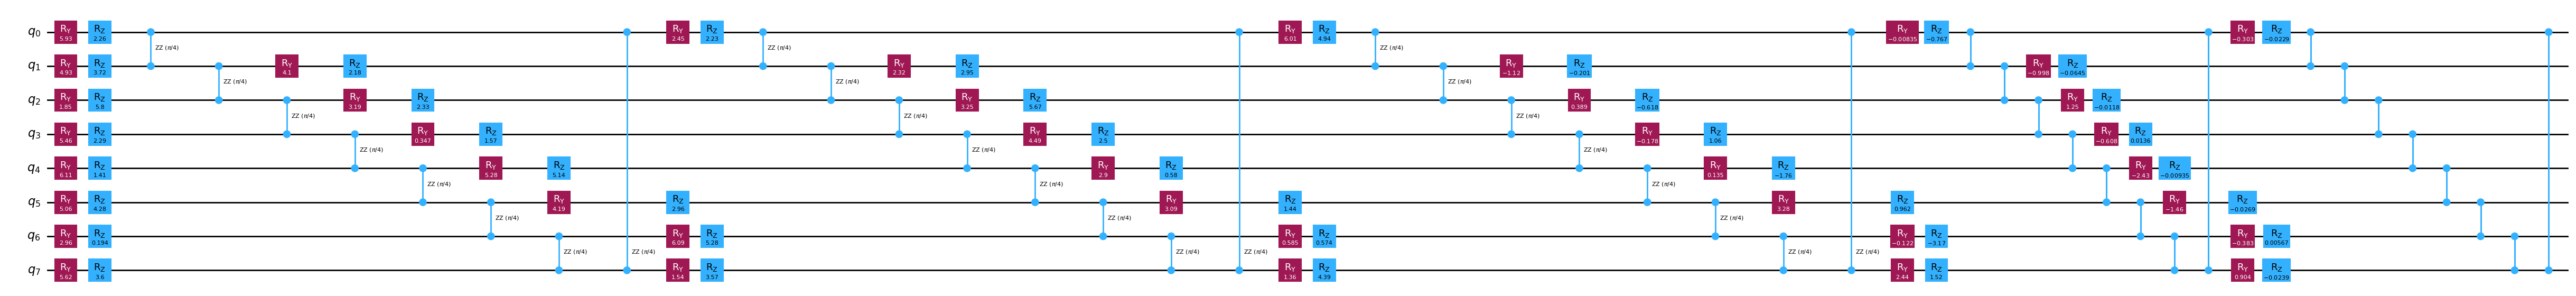

In [14]:
# Load the 8-qubit circuit from before
qc = load_qasm("peaked_circuit_8q_shallow.qasm")
print(qc.count_ops())
qc.draw("mpl", fold=-1)

In [15]:
# Attempt an approximate transpilation of the peaked circuit.
# We use:
#   - basis_gates = set(qc.count_ops()): restricts the transpiler to gates already present
#   - approximation_degree = 0.999: allows small numerical approximations to simplify the circuit
#   - optimization_level = 3: enables aggressive optimizations
qc_tr = transpile(
    qc,
    basis_gates=set(qc.count_ops()),
    approximation_degree=0.999,
    optimization_level=3,
)

# Print the gate counts of the transpiled circuit to see how much simplification occurred
print("Gate counts after approximate transpilation:")
print(qc_tr.count_ops())


Gate counts after approximate transpilation:
OrderedDict([('ry', 39), ('rz', 32), ('rzz', 24), ('cz', 16)])


We observe that the gate count has decreased by 9.  
Let us now verify that the transpiled circuit remains peaked on the same bitstring, `11001101`.

In [16]:
# Run the transpiled circuit
results = bq.run(qc_tr)
probs = results.get_counts()

top10_probs = dict(sorted(probs.items(), key=lambda x: x[1], reverse=True)[:10]) # get top 10
top10_probs 

{'11001101': 0.7257248163223267,
 '11010101': 0.0653160810470581,
 '11010001': 0.049500394612550735,
 '11000001': 0.032261159271001816,
 '10101101': 0.020661847665905952,
 '11001110': 0.018994377925992012,
 '01001110': 0.009922875091433525,
 '11011001': 0.009712910279631615,
 '11001011': 0.008763573132455349,
 '11010011': 0.004192880820482969}

🔍 Not only is the peak bitstring unchanged, but the output distribution remains essentially identical to the original circuit, as evidenced by the top-probability bitstrings.  
This suggests another potential attack strategy on peaked circuits: attempt to simplify the circuit through **approximate transpilation** or by exploiting structural patterns.  
If the circuit admits simplifications without destroying the peak, those simplifications may reveal exploitable regularities.

We conclude with one more example in this direction.  
This time, instead of choosing $d_R > d_P$, we construct a circuit with $d_R = 2$ and $d_P = 3$.  

With a deeper parametric block, the training procedure has more opportunities to introduce **cancellations** (making the resulting peaked circuit potentially more compressible); moreover, we can train the circuit so that the peak bitstring attains **probability weight 1.0**.


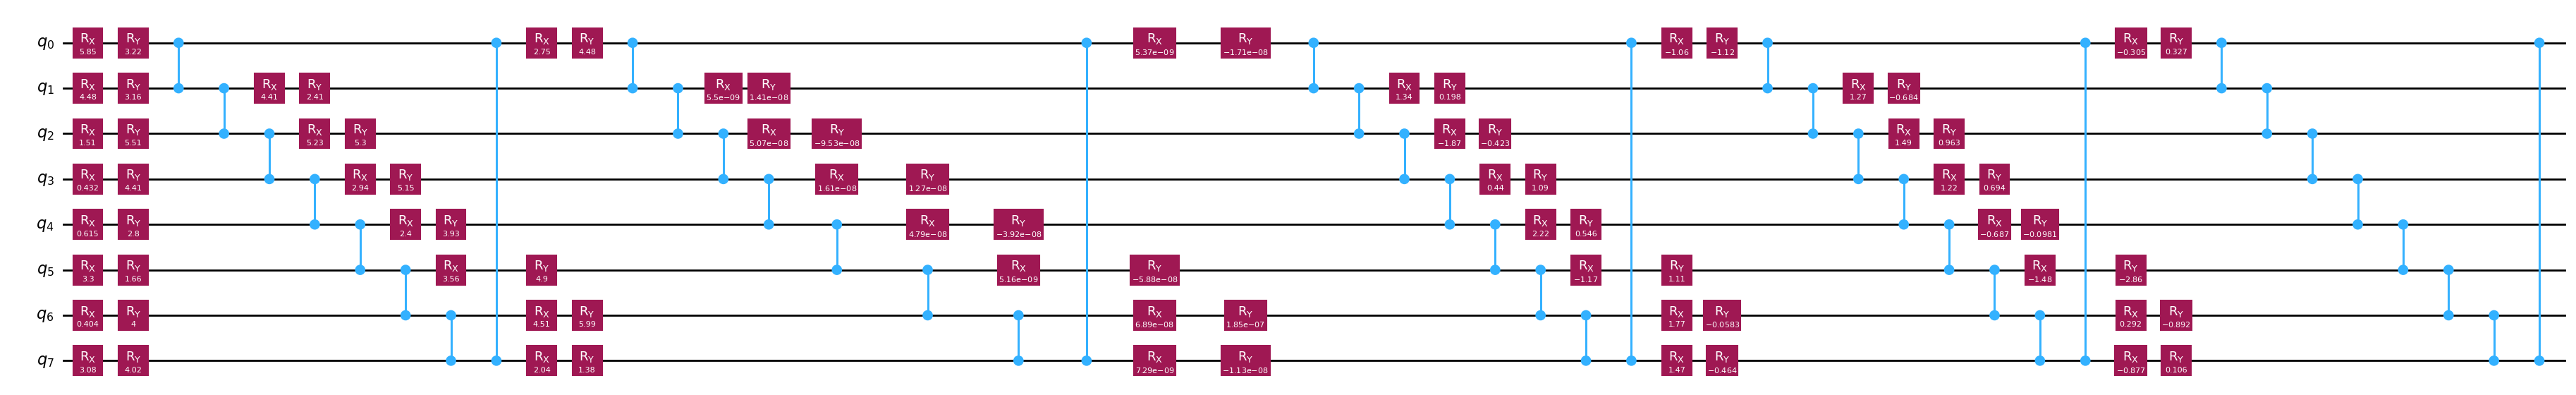

In [17]:
qc = load_qasm("peaked_circuit_8q_cancel.qasm")
qc.draw("mpl", fold=-1)

In [18]:
results = bq.run(qc)
probs = results.get_counts()

top10_probs = dict(sorted(probs.items(), key=lambda x: x[1], reverse=True)[:10]) # get top 10
top10_probs 

{'11000101': 1.0,
 '11000001': 8.725268771381245e-14,
 '11010101': 2.8627352089338406e-14,
 '11001101': 2.2807359909633902e-14,
 '01000101': 2.0794460649383416e-14,
 '11000111': 1.0293108799650473e-14,
 '11000100': 9.122238216001909e-15,
 '10110101': 8.029259088116955e-15,
 '10100101': 6.401866968535003e-15,
 '00000101': 5.155258510391222e-15}

In [19]:
qc_tr = transpile(qc, 
                  basis_gates=set(qc.count_ops()), 
                  approximation_degree=0.999,
                  optimization_level=3,
                 )
print(qc_tr.count_ops())

OrderedDict([('rx', 32), ('ry', 24), ('cz', 24)])


We see that there is significant cancellation: two layers of RY gates, an equal number of CZ gates, and one layer of RX gates are eliminated by the approximate transpilation.  

We leave it to the reader to examine the transpiled circuit below and determine whether it admits any further compression using additional techniques.

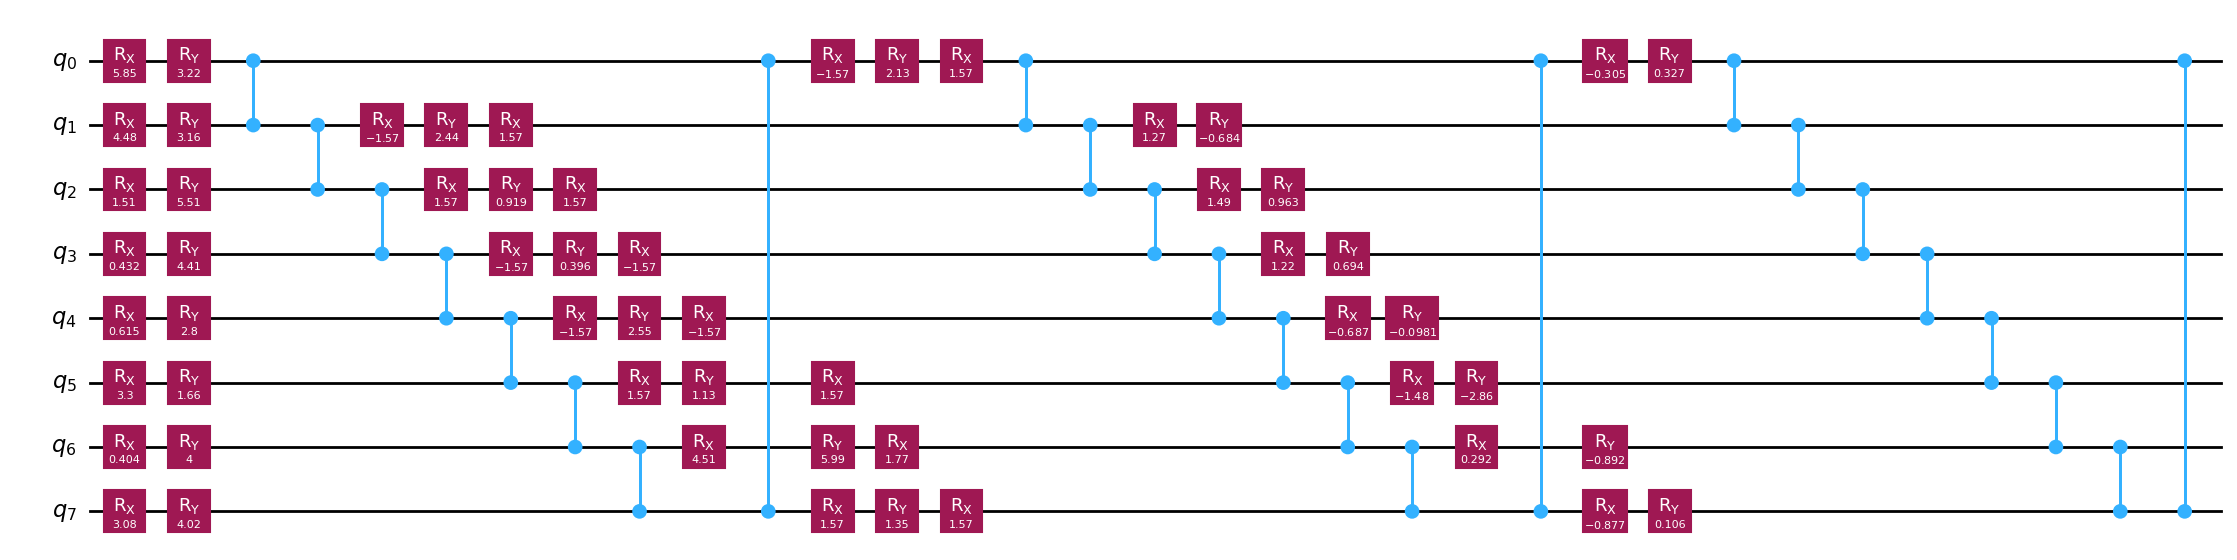

In [20]:
qc_tr.draw("mpl", fold=-1)

Want to explore further? 🚀   
You are invited to try our growing collection of peaked circuits and test your classical attack strategies on even more challenging examples:  
👉 [Join the Peaked Circuits Challenge](https://app.bluequbit.io/hackathons/oEOtLSSrPSVH60Ah)

<h2 id="references">📖 References</h2>

<a id="ref-1"></a> [1] H. Gharibyan, M. Z. Mullath, N. E. Sherman, V. P. Su, H. Tepanyan, and Y. Zhang, “Heuristic Quantum Advantage with Peaked Circuits,” arXiv:2510.25838, 2025. Available: [https://arxiv.org/abs/2510.25838](https://arxiv.org/abs/2510.25838).

<a id="ref-2"></a> [2] S. Aaronson and Y. Zhang, “On verifiable quantum advantage with peaked circuit sampling,” arXiv:2404.14493v2, 2024. Available: [https://arxiv.org/pdf/2404.14493](https://arxiv.org/pdf/2404.14493) 